In [1]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision import models
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
#from einops import rearrange, repeat
#from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum
import cv2
import scipy.misc
#import utils
import tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import pandas as pd

file_path = "sim_squat_data.csv"

df = pd.read_csv(file_path)

print(df.head())

   updown       UWB     vel_x     vel_y     vel_z   accel_x   accel_y  \
0       0  0.591120  0.444669 -0.467373 -0.315034  0.023474 -0.032762   
1       0  0.573637  0.480935 -0.528851 -0.349580 -0.163544  0.073112   
2       0  0.567564  0.402824 -0.462519 -0.375447  0.023747 -0.066839   
3       0  0.549405  0.436299 -0.535916 -0.401144 -0.157985  0.071472   
4       0  0.542702  0.360260 -0.461036 -0.426632 -0.003370  0.012905   

    accel_z    gyro_x    gyro_y    gyro_z  
0 -0.094302  0.133845  0.804320 -0.486455  
1 -0.082049  0.149239  0.865470 -0.586657  
2 -0.033649  0.073584  0.806644 -0.486584  
3 -0.074418  0.248877  0.810755 -0.600475  
4 -0.142077  0.133730  0.725031 -0.480376  


In [3]:
df = df.drop(columns=['vel_x', 'vel_y', 'vel_z'])

In [4]:
tmp = df['updown'].shift(1).fillna(0)
squat_ends = df[(tmp == 1) & (df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = df.iloc[start_index:end_index+1]

    if len(one_set) > 120:
        #one_set = one_set.tail(140)
        squat_sets.append(one_set)
    else:
        print(f"Set too short: {len(one_set)}")

    #squat_sets.append(one_set)
    start_index = end_index + 1

print(f"Total sets: {len(squat_sets)}")

Total squat ends: 3000
Set too short: 120
Total sets: 2999


In [5]:
X = []
y = []
for one_set in squat_sets:
    for i in range(9, len(one_set)-15, 5):
        X.append(one_set.iloc[i-9:i+6, 1:].values)
        y.append(one_set.iloc[i]['updown'])

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(70540, 15, 7) (70540,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
class biGRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biGRU, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        #h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, 10, :]) # 과거 10개, 현재 5개
        #out = self.fc(out[:, -1, :]) # 과거 15개개

        return out

In [8]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import torch.nn.init as init
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

def initialize_gru_weights(gru):
    for name, param in gru.named_parameters():
        if 'weight' in name:
            init.xavier_uniform_(param.data)
        elif 'bias' in name:
            init.constant_(param.data, 0)

# 초기화 실행
set_seed(42)
model = biGRU(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
model.apply(initialize_weights)
initialize_gru_weights(model.gru)

In [10]:
real_df = pd.read_csv("real_squat_data.csv")

real_df.head()

,UWB,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,updown
0,0.723169,0.847622,-0.831826,1.067376,-1.483318,0.816265,0.329999,0
1,0.723169,-0.305767,0.605308,0.871359,-0.961083,0.751001,0.850115,0
2,0.795571,-0.305767,0.605308,0.871359,-0.961083,0.751001,0.850115,0
3,0.867973,2.503732,-0.901515,0.520150,-0.353930,0.990736,0.576363,0
4,0.766610,2.503732,-0.901515,0.520150,-0.353930,0.990736,0.576363,0


In [11]:
tmp = real_df['updown'].shift(1).fillna(0)
squat_ends = real_df[(tmp == 1) & (real_df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")
print(squat_ends)

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = real_df.iloc[start_index:end_index+1]

    squat_sets.append(one_set)
    print(f"len of oneset:{len(one_set)}")
    #squat_sets.append(one_set)
    print(f"start_index: {start_index}, end_index: {end_index}")
    start_index = end_index + 1


print(f"Total sets: {len(squat_sets)}")


Total squat ends: 67
Index([  95,  184,  272,  369,  450,  528,  602,  671,  791,  883,  982, 1077,
       1172, 1263, 1351, 1444, 1544, 1636, 1719, 1805, 1896, 1983, 2071, 2158,
       2251, 2355, 2431, 2511, 2599, 2691, 2779, 2868, 2955, 3040, 3132, 3214,
       3303, 3390, 3479, 3558, 3638, 3712, 3787, 3867, 3953, 4032, 4115, 4201,
       4296, 4380, 4450, 4517, 4603, 4684, 4763, 4844, 4926, 5005, 5086, 5166,
       5257, 5322, 5396, 5480, 5557, 5650, 5741],
      dtype='int64')
len of oneset:96
start_index: 0, end_index: 95
len of oneset:89
start_index: 96, end_index: 184
len of oneset:88
start_index: 185, end_index: 272
len of oneset:97
start_index: 273, end_index: 369
len of oneset:81
start_index: 370, end_index: 450
len of oneset:78
start_index: 451, end_index: 528
len of oneset:74
start_index: 529, end_index: 602
len of oneset:69
start_index: 603, end_index: 671
len of oneset:120
start_index: 672, end_index: 791
len of oneset:92
start_index: 792, end_index: 883
len of oneset:99

In [12]:
X_test = []
y_test = []

for one_set in squat_sets:
    for i in range(9, len(one_set)-15, 5):
        X_test.append(one_set.iloc[i-9:i+6, 1:].values)
        y_test.append(one_set.iloc[i]['updown'])

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(853, 15, 7) (853,)


In [13]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [15]:
print(model)

biGRU(
  (gru): GRU(7, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [16]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [17]:
def evaluate(model, data_loader, criterion, device, phase="validation"):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"Evaluating {phase}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Accuracy: {accuracy:.2f}%")
    if phase == "validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
    if phase == "test":
        test_accuracy = accuracy
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions

In [18]:
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="validation")

Epoch [1/50]


Train Loss: 0.0038, Train Accuracy: 94.53%


Validation Loss: 0.0022, Validation Accuracy: 97.08%
Best model saved!
Epoch [2/50]


Train Loss: 0.0019, Train Accuracy: 97.64%


Validation Loss: 0.0023, Validation Accuracy: 97.14%
Best model saved!
Epoch [3/50]


Train Loss: 0.0016, Train Accuracy: 98.04%


Validation Loss: 0.0017, Validation Accuracy: 98.16%
Best model saved!
Epoch [4/50]


Train Loss: 0.0013, Train Accuracy: 98.31%


Validation Loss: 0.0015, Validation Accuracy: 97.91%
Epoch [5/50]


Train Loss: 0.0012, Train Accuracy: 98.42%


Validation Loss: 0.0011, Validation Accuracy: 98.59%
Best model saved!
Epoch [6/50]


Train Loss: 0.0011, Train Accuracy: 98.59%


Validation Loss: 0.0011, Validation Accuracy: 98.75%
Best model saved!
Epoch [7/50]


Train Loss: 0.0010, Train Accuracy: 98.73%


Validation Loss: 0.0013, Validation Accuracy: 98.39%
Epoch [8/50]


Train Loss: 0.0010, Train Accuracy: 98.78%


Validation Loss: 0.0010, Validation Accuracy: 98.94%
Best model saved!
Epoch [9/50]


Train Loss: 0.0009, Train Accuracy: 98.83%


Validation Loss: 0.0011, Validation Accuracy: 98.99%
Best model saved!
Epoch [10/50]


Train Loss: 0.0009, Train Accuracy: 98.87%


Validation Loss: 0.0010, Validation Accuracy: 98.98%
Epoch [11/50]


Train Loss: 0.0009, Train Accuracy: 98.91%


Validation Loss: 0.0010, Validation Accuracy: 99.01%
Best model saved!
Epoch [12/50]


Train Loss: 0.0008, Train Accuracy: 98.98%


Validation Loss: 0.0009, Validation Accuracy: 99.16%
Best model saved!
Epoch [13/50]


Train Loss: 0.0008, Train Accuracy: 99.00%


Validation Loss: 0.0009, Validation Accuracy: 99.14%
Epoch [14/50]


Train Loss: 0.0008, Train Accuracy: 98.99%


Validation Loss: 0.0009, Validation Accuracy: 99.04%
Epoch [15/50]


Train Loss: 0.0007, Train Accuracy: 99.04%


Validation Loss: 0.0011, Validation Accuracy: 98.92%
Epoch [16/50]


Train Loss: 0.0007, Train Accuracy: 99.09%


Validation Loss: 0.0008, Validation Accuracy: 99.11%
Epoch [17/50]


Train Loss: 0.0007, Train Accuracy: 99.12%


Validation Loss: 0.0008, Validation Accuracy: 99.14%
Epoch [18/50]


Train Loss: 0.0007, Train Accuracy: 99.14%


Validation Loss: 0.0008, Validation Accuracy: 98.97%
Epoch [19/50]


Train Loss: 0.0006, Train Accuracy: 99.15%


Validation Loss: 0.0008, Validation Accuracy: 99.02%
Epoch [20/50]


Train Loss: 0.0006, Train Accuracy: 99.20%


Validation Loss: 0.0007, Validation Accuracy: 99.21%
Best model saved!
Epoch [21/50]


Train Loss: 0.0006, Train Accuracy: 99.19%


Validation Loss: 0.0007, Validation Accuracy: 99.25%
Best model saved!
Epoch [22/50]


Train Loss: 0.0006, Train Accuracy: 99.22%


Validation Loss: 0.0008, Validation Accuracy: 99.09%
Epoch [23/50]


Train Loss: 0.0006, Train Accuracy: 99.21%


Validation Loss: 0.0008, Validation Accuracy: 99.16%
Epoch [24/50]


Train Loss: 0.0006, Train Accuracy: 99.24%


Validation Loss: 0.0007, Validation Accuracy: 99.11%
Epoch [25/50]


Train Loss: 0.0006, Train Accuracy: 99.23%


Validation Loss: 0.0007, Validation Accuracy: 99.16%
Epoch [26/50]


Train Loss: 0.0006, Train Accuracy: 99.27%


Validation Loss: 0.0007, Validation Accuracy: 99.29%
Best model saved!
Epoch [27/50]


Train Loss: 0.0006, Train Accuracy: 99.27%


Validation Loss: 0.0007, Validation Accuracy: 99.28%
Epoch [28/50]


Train Loss: 0.0006, Train Accuracy: 99.28%


Validation Loss: 0.0007, Validation Accuracy: 99.16%
Epoch [29/50]


Train Loss: 0.0005, Train Accuracy: 99.29%


Validation Loss: 0.0007, Validation Accuracy: 99.29%
Epoch [30/50]


Train Loss: 0.0006, Train Accuracy: 99.27%


Validation Loss: 0.0007, Validation Accuracy: 99.19%
Epoch [31/50]


Train Loss: 0.0005, Train Accuracy: 99.30%


Validation Loss: 0.0007, Validation Accuracy: 99.26%
Epoch [32/50]


Train Loss: 0.0005, Train Accuracy: 99.26%


Validation Loss: 0.0007, Validation Accuracy: 99.29%
Epoch [33/50]


Train Loss: 0.0005, Train Accuracy: 99.33%


Validation Loss: 0.0007, Validation Accuracy: 99.32%
Best model saved!
Epoch [34/50]


Train Loss: 0.0005, Train Accuracy: 99.32%


Validation Loss: 0.0007, Validation Accuracy: 99.17%
Epoch [35/50]


Train Loss: 0.0005, Train Accuracy: 99.34%


Validation Loss: 0.0006, Validation Accuracy: 99.23%
Epoch [36/50]


Train Loss: 0.0005, Train Accuracy: 99.35%


Validation Loss: 0.0007, Validation Accuracy: 99.16%
Epoch [37/50]


Train Loss: 0.0005, Train Accuracy: 99.36%


Validation Loss: 0.0007, Validation Accuracy: 99.24%
Epoch [38/50]


Train Loss: 0.0005, Train Accuracy: 99.36%


Validation Loss: 0.0007, Validation Accuracy: 99.32%
Epoch [39/50]


Train Loss: 0.0005, Train Accuracy: 99.38%


Validation Loss: 0.0006, Validation Accuracy: 99.31%
Epoch [40/50]


Train Loss: 0.0005, Train Accuracy: 99.37%


Validation Loss: 0.0007, Validation Accuracy: 99.21%
Epoch [41/50]


Train Loss: 0.0005, Train Accuracy: 99.38%


Validation Loss: 0.0006, Validation Accuracy: 99.28%
Epoch [42/50]


Train Loss: 0.0005, Train Accuracy: 99.39%


Validation Loss: 0.0006, Validation Accuracy: 99.31%
Epoch [43/50]


Train Loss: 0.0004, Train Accuracy: 99.42%


Validation Loss: 0.0006, Validation Accuracy: 99.33%
Best model saved!
Epoch [44/50]


Train Loss: 0.0004, Train Accuracy: 99.43%


Validation Loss: 0.0006, Validation Accuracy: 99.31%
Epoch [45/50]


Train Loss: 0.0004, Train Accuracy: 99.42%


Validation Loss: 0.0007, Validation Accuracy: 99.34%
Best model saved!
Epoch [46/50]


Train Loss: 0.0004, Train Accuracy: 99.42%


Validation Loss: 0.0007, Validation Accuracy: 99.21%
Epoch [47/50]


Train Loss: 0.0004, Train Accuracy: 99.43%


Validation Loss: 0.0006, Validation Accuracy: 99.31%
Epoch [48/50]


Train Loss: 0.0004, Train Accuracy: 99.46%


Validation Loss: 0.0007, Validation Accuracy: 99.11%
Epoch [49/50]


Train Loss: 0.0004, Train Accuracy: 99.50%


Validation Loss: 0.0007, Validation Accuracy: 99.24%
Epoch [50/50]


Train Loss: 0.0004, Train Accuracy: 99.49%


Validation Loss: 0.0006, Validation Accuracy: 99.33%


In [19]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="test")

Test Loss: 0.1321, Test Accuracy: 55.80%
Test Accuracy: 55.80%


In [20]:
print(f"F1 Score: {f1_score_result:.4f}")
print(f"Recall Score: {recall_score_result:.4f}")
print(f"Precision Score: {precision_score_result:.4f}")

F1 Score: 0.6447
Recall Score: 0.8571
Precision Score: 0.5166


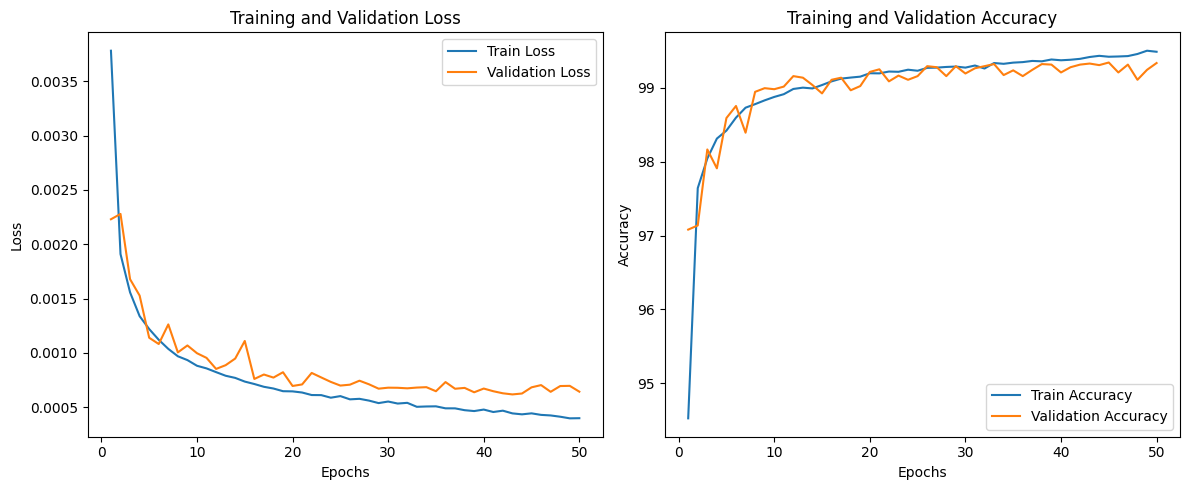

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()